In [2]:
import cv2
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from instrumental.drivers.cameras import uc480



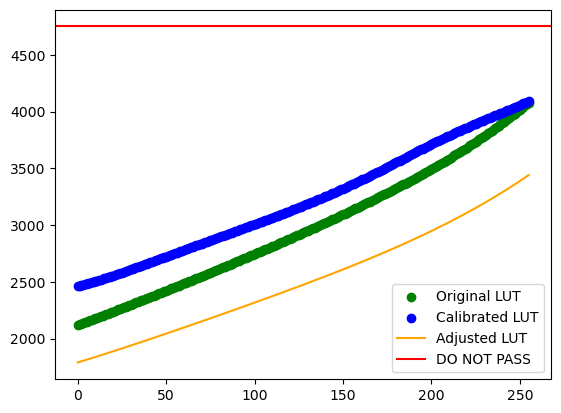

[ 2.17002417e-07 -6.51380082e-05  1.05010946e-02  5.63437574e+00
  2.12203814e+03]


In [4]:
### Section 1
## THIS SECTION IS MEANT TO TEST THE GENERATED LUT FILE. 
## If you are generating a new LUT file, scroll down to Section 2. 
# LUT File generator: Play around with fits to data
pix, vol = np.loadtxt("calibrationfile.txt", delimiter = ' ', usecols=(0,1), unpack = True)
pix1, vol1 = np.loadtxt("slm650good.txt", delimiter = ' ', usecols=(0,1), unpack = True)

def polyfit(x,a,b,c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

params, cov = curve_fit(polyfit, pix, vol)
a,b,c,d,e = params
## Adjust parameters
e *= 1
d *= 1
c *= 1
b *= 1
a *= 1
adjparams = a,b,c,d,e

pixsample = np.linspace(pix[0],pix[-1], num = 256)
voltsample = polyfit(pixsample, *adjparams)

calculated = 650 / 785 / np.cos(11/180*np.pi)

plt.scatter(pix,vol, color='green', label='Original LUT')
plt.scatter(pix1,vol1, color='blue', label='Calibrated LUT')

plt.plot(pixsample, voltsample*calculated, color = 'orange', label='Adjusted LUT')
plt.axhline(y=4750, color = 'red', label = 'DO NOT PASS')
plt.legend()
plt.show()

print(params)


In [7]:
# LUT File generator: If above graph looks good, export as text file.
data = np.column_stack((pixsample, voltsample))
np.savetxt('modeledvoltages.LUT', data, fmt ='%d')

In [4]:
### Section 2
## Here we will calibrate the LUT file by passing in slightly different diffraction gratings
## We will then measure the intensity of the 1st (or 0th) order diffraction as we pass different gratings
## Pay attention!!! to make sure that you don't oversaturate or undersaturate the camera while measuring.

## Step 1: Testing the camera works, troubleshoot
# init camera (Using a UC480 camera, dependent on which camera you use this will have to be adapted)
instruments = uc480.list_instruments()
cam = uc480.UC480_Camera(instruments[0])

# params
cam.start_live_video(framerate = "10Hz")

while cam.is_open:
     
     frame = cam.grab_image(timeout='100s', copy=True, exposure_time='60ms')
     
     frame1 = np.stack((frame,) * 3,-1) #make frame as 1 channel image
     frame1 = frame1.astype(np.uint8)

     gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

     #now u can apply opencv features

     cv2.imshow('Camera', gray)
     
     if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cam.close()
cv2.destroyAllWindows()

IndexError: list index out of range

In [1]:
## Step 2: Trail run to troubleshoot camera linking, finding zeroth order point location, and making sure stuff runs. 
# The biggest challenge here is probably finding the 0th order and making sure the location is stable.
# If we are working in an unstable environment, might be worth using cv2 to find the location of 0th order spot.
# However, there are print lines scattered throughout the code to help pinpoint where things go FUBAR.

import os
from ctypes import *
from scipy import misc
from time import sleep
import cv2
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from instrumental.drivers.cameras import uc480



#%%%%%%%%%%%%%%%%%%% LOAD MANUFACTURER PROGRAMS AND DLLS- START %%%%%%%%%%%%%%%%%%%%%%%%%

################################ MAKE SURE THE WINDOW SHOWS UP IN THE WRITE PLACE FOR THE DPI SETTINGS#############
# Query DPI Awareness (Windows 10 and 8)
import ctypes
awareness = ctypes.c_int()
errorCode = ctypes.windll.shcore.GetProcessDpiAwareness(0, ctypes.byref(awareness))
print(awareness.value)
# Set DPI Awareness  (Windows 10 and 8)
errorCode = ctypes.windll.shcore.SetProcessDpiAwareness(2)
# the argument is the awareness level, which can be 0, 1 or 2:
# for 1-to-1 pixel control I seem to need it to be non-zero (I'm using level 2)

# Set DPI Awareness  (Windows 7 and Vista)
success = ctypes.windll.user32.SetProcessDPIAware()
# behaviour on later OSes is undefined, although when I run it on my Windows 10 machine, it seems to work with effects identical to SetProcessDpiAwareness(1)
#######################################################################################################################
# Load the DLL
# Blink_C_wrapper.dll, HdmiDisplay.dll, ImageGen.dll, freeglut.dll and glew64.dll
# should all be located in the same directory as the program referencing the
# library
cdll.LoadLibrary("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\SDK\\Blink_C_wrapper")
slm_lib = CDLL("Blink_C_wrapper")

# Open the image generation library
cdll.LoadLibrary("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\SDK\\ImageGen")
image_lib = CDLL("ImageGen")
#%%%%%%%%%%%%%%%%%%% LOAD MANUFACTURER PROGRAMS AND DLLS - FIN. %%%%%%%%%%%%%%%%%%%%%%%%%

#%%%%%%%%%%%%%%%%%%% Setup calibration settings %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# init camera
instruments = uc480.list_instruments()
cam = uc480.UC480_Camera(instruments[0])
# Start camera
cam.start_live_video(framerate = "10Hz")

print("Camera Loaded")

RGB = c_uint(1)
is_eight_bit_image = c_uint(0)
# In the real run we'll do NumDataPoints = 255 to get all possible voltage values, but for this trial run 10 is fine.
NumDataPoints = 10
NumRegions = 1 ## If we need regional calibration, set this to 64
slm_lib.Create_SDK(c_uint(1)) # Initialize SDK, c_unit(1) means true
print("Created SDK")

### numFrames determines how many times we will take a picture of a set diffraction grating. I recommend 3~5 to get a good average. 
numFrames = 5
height = c_uint(slm_lib.Get_Height())
width = c_uint(slm_lib.Get_Width())
depth = c_uint(slm_lib.Get_Depth())
center_x = c_uint(width.value//2)
center_y = c_uint(height.value//2)

success = 0
success = slm_lib.Load_lut("C:\\Program Files\\Meadowlark Optics\\Blink 1920 HDMI\\LUT Files\\19x12_8bit_linearVoltage.lut")
print("Load LUT success")
#these arrays hold our data points. 
Image = np.empty([width.value*height.value*3], np.uint8, 'C')
WFC = np.zeros([width.value*height.value*3], np.uint8, 'C')
AI_Intensities = np.zeros([NumDataPoints], np.float32, 'C')
image_lib.Generate_Solid(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, c_uint(0), RGB)
print("Generate Image success")
slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), c_uint(1))
print("Write Image success")

PixelValueOne = c_uint(255)
PixelsPerStripe = c_uint(128)

#the loops are a bit redundant, but let's keep them just in case we want to do regional calibrations later.
for region in range(0,NumRegions,1):
    print("Region: %d\n", region)
    for gray in range(0,NumDataPoints,1):
        print("Gray: %d\r", gray)
        PixelValueTwo = c_uint(255-gray)
        image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
        image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
        slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
        sleep(0.03)
        net = 0
        for frames in range(0, numFrames, 1):
            #Important: exposure_time can be set to your liking, choose one that's best for saturation
            frame = cam.grab_image(timeout='100s', copy=True, exposure_time='10ms')
            numpix = 0 
            #this region has to be handled by you!!! Find the region where the 0th order / 1st order spot is
            #You can average over nearby pixels, take the max value, or something else. 
            #You can find where the desired spot is by passing a diffraction grating to the SLM manually and opening the Thorlabs camera in Python. Then translate camera to an array, find points on array, and put in coords. Code for this should be available above.
            for xrange in range(591,593,1):
                for yrange in range(676,678,1):
                    net = net +frame[xrange,yrange]
                    numpix = numpix + 1
            net = net / numpix
        AI_Intensities[gray] = net / numFrames
        print(net)
        # this will give you an indicator of your pixel values. make sure there's no over/under saturation!

print(AI_Intensities)

0
Camera Loaded
Created SDK
Load LUT success
Generate Image success
Write Image success
Region: %d
 0
 0ay: %d
1.33203125
 1ay: %d
1.26953125
 2ay: %d
1.3271484375
 3ay: %d
1.33203125
 4ay: %d
1.33203125
 5ay: %d
1.33203125
 6ay: %d
1.25
 7ay: %d
1.31640625
 8ay: %d
1.3271484375
 9ay: %d
1.33203125
[0.26640624 0.25390625 0.26542968 0.26640624 0.26640624 0.26640624
 0.25       0.26328126 0.26542968 0.26640624]


In [20]:
# Run this to find the location of the 0th or 1st order diffraction spot so you can adapt range. 
NumDataPoints = 256
NumFrames = 5
AI_Intensities = np.zeros([NumDataPoints], np.float32, 'C')
map = cam.grab_image(timeout='100s', copy=True, exposure_time = '3ms')
print(map[470:485,635:645])

[[  2   3   6   6   3   3   4   5   5   4]
 [  2   2   6   8   8   8   8   6   5   4]
 [  3   3  11  19  18  12   7   3   3   3]
 [  5   4  21  32  22   9   4   3   3   2]
 [  6   5  21  40  35  21  12   8   9   8]
 [ 10   5  14  48  73  68  39  18  14  18]
 [ 14  12  10  53 109 122  75  27  14  24]
 [ 16  21  15  48 110 134  84  28  10  21]
 [ 14  22  18  32  74  99  68  24   6  13]
 [  9  15  12  16  36  55  45  19   4   9]
 [  4   6   6   8  17  29  26  12   4   6]
 [  1   3   4   5   9  15  14   6   2   4]
 [  1   2   4   4   4   6   6   3   2   2]
 [  1   2   2   3   2   2   2   2   1   1]
 [  1   1   2   2   2   1   1   1   1   1]]


In [21]:
### Step 3: Get your intensity values!
# once you find the location, let's run that loop once more. Note that the camera should still be open, the SLM
# should still be initialized, and we are good to go. IF stuff doesn't run, just try restarting the notebook and running cells from
# top to bottom. For some reason the SLM's shutdown function doesn't work(?) so I've just been restarting the notebook to
# close the SLM. 

for region in range(0,NumRegions,1):
    print("Region: %d\n", region)
    for gray in range(0,NumDataPoints,1):
        print("Gray: %d\r", gray)
        PixelValueTwo = c_uint(255-gray)
        image_lib.Generate_Stripe(Image.ctypes.data_as(POINTER(c_ubyte)), WFC.ctypes.data_as(POINTER(c_ubyte)), width, height, depth, PixelValueOne, PixelValueTwo, PixelsPerStripe, RGB)
        image_lib.Mask_Image(Image.ctypes.data_as(POINTER(c_ubyte)), width, height,depth,region,c_uint(NumRegions),RGB)
        slm_lib.Write_image(Image.ctypes.data_as(POINTER(c_ubyte)), is_eight_bit_image)
        # set a 30ms delay to let SLM settle.
        sleep(0.03)
        net = 0
        ##net = np.sum(map[509:512,644:647])
        map = cam.grab_image(timeout='100s', copy=True, exposure_time = '3ms')
        #change map[] to desired coordinates of spot. 
        net = np.max(map[470:485,635:645]) +net
        map = cam.grab_image(timeout='100s', copy=True, exposure_time = '3ms')
        net = np.max(map[470:485,635:645]) +net
        map = cam.grab_image(timeout='100s', copy=True, exposure_time = '3ms')
        net = np.max(map[470:485,635:645]) +net
        map = cam.grab_image(timeout='100s', copy=True, exposure_time = '3ms')
        net = np.max(map[470:485,635:645]) +net
        net = net/4
        AI_Intensities[gray] = net
        print(net)
## Again, make sure there's no over/undersaturation. If there is, it's time to adjust exposure time or dark lens.
print(AI_Intensities)

Region: %d
 0
 0ay: %d
137.75
 1ay: %d
140.0
 2ay: %d
136.0
 3ay: %d
138.0
 4ay: %d
136.5
 5ay: %d
134.75
 6ay: %d
131.0
 7ay: %d
130.5
 8ay: %d
131.75
 9ay: %d
127.0
 10y: %d
126.25
 11y: %d
126.0
 12y: %d
122.25
 13y: %d
119.75
 14y: %d
121.25
 15y: %d
113.75
 16y: %d
110.0
 17y: %d
107.5
 18y: %d
105.0
 19y: %d
105.75
 20y: %d
100.5
 21y: %d
96.75
 22y: %d
92.25
 23y: %d
89.25
 24y: %d
86.5
 25y: %d
82.0
 26y: %d
79.25
 27y: %d
77.25
 28y: %d
73.0
 29y: %d
70.25
 30y: %d
66.25
 31y: %d
62.75
 32y: %d
60.0
 33y: %d
56.75
 34y: %d
54.5
 35y: %d
50.75
 36y: %d
47.75
 37y: %d
45.0
 38y: %d
44.25
 39y: %d
39.5
 40y: %d
36.5
 41y: %d
34.0
 42y: %d
30.5
 43y: %d
27.5
 44y: %d
25.0
 45y: %d
23.25
 46y: %d
20.5
 47y: %d
18.5
 48y: %d
16.25
 49y: %d
15.5
 50y: %d
13.75
 51y: %d
12.75
 52y: %d
11.25
 53y: %d
10.5
 54y: %d
9.75
 55y: %d
9.25
 56y: %d
9.0
 57y: %d
8.25
 58y: %d
7.5
 59y: %d
7.0
 60y: %d
7.75
 61y: %d
9.25
 62y: %d
10.5
 63y: %d
12.0
 64y: %d
14.25
 65y: %d
17.0
 66y: %d
18.5
 67

In [22]:
#Step 4: If everything looks good, export to csv file.
AI_Intensities = AI_Intensities / np.max(AI_Intensities) * 255
AI_Intensities.flatten()
numbers = np.arange(256)
csvdata = np.stack((numbers,AI_Intensities),axis=1)
np.savetxt('Raw0.csv',csvdata, delimiter = ",", fmt='%s')